DS312 Homework 2: Linear Regression with PCA
============================================
### Calvin Henggeler
### Fall 2023

Use the data county_info.csv under Files > data.

1. Compute the annual population growth rate (%) over the time period.
2. Compute the annual house value growth rate (%) over the time period
3. Compute the annual birth rate over the measured time period.
4. Use features: pop_foreigen_born, adult obesity rate, pop/sq mi, pop pct urban, poverty rate, median income, cost of living, annual pop growth rate,
   annual house value growth rate. You should drop any rows lacking entries for any of the features (but do not drop any rows which have figures for all these features).
   Adjust all dollar figures to 2022/03/01 using python's CPI package.
5. Use linear regression to model the median house value in 2000 as a function of the features. Don't forget to split the data into training, validation, and test sets.
6. Report the coefficient for each feature. Are there any which make you suspect multicollinearity?
7. Investigate multicollinearity among the features by plotting the correlation heatmap.
8. Normalize the data, then use PCA to transform the features into a new linearly independent feature set.
9. Describe the principal (first) component as a linear combination of the given features.
10. For k = 1, ...,n, train a linear model on the first k components, and score on the validation set.
11. Graph the score vs number of components.
12. Include on the same graph variance explained vs number of components.

In [1]:
import pandas as pd
import numpy as np
import cpi
from datetime import date
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

ModuleNotFoundError: No module named 'cpi'

In [264]:
df = pd.read_csv('county_info.csv')

In [244]:
df.head()

,fips,state,county,pop_in_later_year,pop_ref_later_year,pop_f,pop_m,pop_in_2000,median_age,median_age_f,...,births_to_yr_int2,pop_foreign_born,land_area_km2,land_area_mi2,water_area_km2,water_area_mi2,total_area_km2,total_area_mi2,latitude,longitude
0,1001,AL,Autauga,55308.0,2017,28306.0,27002.0,43671.0,38.0,39.2,...,2006.0,1170.0,1539.582,594.436,25.776,9.952,1565.358,604.388,32.536382,-86.644490
1,1003,AL,Baldwin,212628.0,2017,107930.0,104698.0,140415.0,42.6,44.3,...,2006.0,10881.0,4117.522,1589.784,1133.190,437.527,5250.712,2027.311,30.659218,-87.746067
2,1005,AL,Barbour,26330.0,2017,12301.0,14029.0,29038.0,39.9,43.3,...,2006.0,701.0,2291.819,884.876,50.865,19.639,2342.684,904.515,31.870670,-85.405456
3,1007,AL,Bibb,22691.0,2017,10393.0,12298.0,20826.0,40.0,43.6,...,2006.0,232.0,1612.481,622.582,9.289,3.587,1621.770,626.169,33.015893,-87.127148
4,1009,AL,Blount,57952.0,2017,29352.0,28600.0,51024.0,41.1,42.6,...,2006.0,2638.0,1669.962,644.776,15.157,5.852,1685.119,650.628,33.977448,-86.567246


In [245]:
df.describe()

,fips,pop_in_later_year,pop_ref_later_year,pop_f,pop_m,pop_in_2000,median_age,median_age_f,median_age_m,median_house_income_2017,...,births_to_yr_int2,pop_foreign_born,land_area_km2,land_area_mi2,water_area_km2,water_area_mi2,total_area_km2,total_area_mi2,latitude,longitude
count,3144.000000,3.143000e+03,3144.000000,3.143000e+03,3.143000e+03,3.140000e+03,3144.000000,3138.000000,3138.000000,3144.000000,...,3142.0,3.143000e+03,3144.000000,3144.000000,3142.000000,3142.000000,3144.000000,3144.000000,3144.000000,3144.000000
mean,30426.815840,1.046328e+05,2016.538486,5.311072e+04,5.152209e+04,9.028927e+04,41.477195,42.799968,40.241714,51610.303753,...,2006.0,1.435947e+04,2909.230355,1123.260163,218.300708,84.286379,3127.392193,1207.492925,38.446272,-92.255665
std,15162.977553,3.339503e+05,0.657162,1.699278e+05,1.640617e+05,2.934152e+05,5.389288,5.474568,5.463137,13653.386549,...,0.0,9.346699e+04,9352.259303,3610.927669,1217.424055,470.050078,9912.130123,3827.095010,5.292499,12.937532
min,1001.000000,7.900000e+01,2005.000000,3.800000e+01,4.100000e+01,6.700000e+01,21.700000,22.600000,21.300000,20025.000000,...,2006.0,0.000000e+00,5.177000,1.999000,0.003000,0.001000,5.177000,1.999000,19.597764,-178.338813
25%,18182.500000,1.119100e+04,2016.000000,5.555000e+03,5.646000e+03,1.127400e+04,38.200000,39.500000,36.900000,42632.750000,...,2006.0,1.920000e+02,1115.376000,430.649250,7.156000,2.763250,1154.607750,445.796750,34.699969,-98.217051
50%,29182.000000,2.626200e+04,2017.000000,1.310700e+04,1.313600e+04,2.475200e+04,41.500000,43.000000,40.100000,49810.000000,...,2006.0,6.680000e+02,1594.389500,615.597500,19.373000,7.480000,1686.876500,651.307000,38.363697,-90.360508
75%,45087.500000,6.787050e+04,2017.000000,3.414150e+04,3.412500e+04,6.213825e+04,44.500000,46.000000,43.300000,57890.250000,...,2006.0,2.961500e+03,2392.932250,923.916000,60.647000,23.416000,2552.592000,985.561750,41.808187,-83.417609
max,56045.000000,1.016351e+07,2017.000000,5.153936e+06,5.009571e+06,9.519338e+06,67.600000,67.800000,67.200000,135842.000000,...,2006.0,3.482367e+06,376855.656000,145504.789000,25190.644000,9726.162000,382812.220000,147804.631000,69.449343,-67.609354


In [246]:
df.shape

(3144, 50)

In [247]:
# 1) Annual population growth rate percentage
# Compound Annual Growth Rate = ( (EV/BV)^(1/n) - 1 ) * 100 where
# BV: Beginning value
# EV: Ending value
# n : Number of years
# https://www.investopedia.com/terms/c/cagr.asp#:~:text=Divide%20the%20value%20of%20an,the%20answer%20into%20a%20percentage.
df['annual_pop_growth_rate'] = ((df['pop_in_later_year']/df['pop_in_2000'])**(1/(df['pop_ref_later_year']-2000))-1) * 100
df['annual_pop_growth_rate'].head()

0    1.399308
1    2.470867
2   -0.574206
3    0.505782
4    0.751747
Name: annual_pop_growth_rate, dtype: float64

In [248]:
# 2) Annual House value growth rate percentage
df['annual_house_value_growth_rate'] = ((df['median_house_value_2017']/df['median_house_value_2000'])**(1/(2017-2000))-1) * 100
df['annual_house_value_growth_rate'].head()

0    3.698346
1    3.839544
2    3.062253
3    4.056521
4    3.169685
Name: annual_house_value_growth_rate, dtype: float64

In [265]:
# 3) Annual birth rate over measured period

#get annual rate given rate per 1000 people
annual_births_per_1000_int1 = df['birth_per_1000_int1'] / (df['births_to_yr_int1'] - df['births_from_yr_int1'])
annual_births_per_1000_int2 = df['birth_per_1000_int2'] / (df['births_to_yr_int2'] - df['births_from_yr_int2'])

# Take average of intervals
df['annual_births_per_1000'] = (annual_births_per_1000_int1 + annual_births_per_1000_int2) / 2

In [250]:
# 4) Define features
features =  ['pop_foreign_born' , 'adult_obes_rate', 'pop_per_sq_mi', 'pop_percent_urban',
             'poverty_pct', 'median_house_income_ref_val', 'median_house_income_ref_yr', 'median_house_income_2017',
             'cost_of_living_usd', 'annual_pop_growth_rate', 'annual_house_value_growth_rate']
target =    ['median_house_value_2000']

df = df[features+target]
df.dropna(inplace=True) # drop rows with missing values
df.head()

,pop_foreign_born,adult_obes_rate,pop_per_sq_mi,pop_percent_urban,poverty_pct,median_house_income_ref_val,median_house_income_ref_yr,median_house_income_2017,cost_of_living_usd,annual_pop_growth_rate,annual_house_value_growth_rate,median_house_value_2000
0,1170.0,30.0,93,58.0,12.9,42013,1999,57282,86.5,1.399308,3.698346,82500.0
1,10881.0,24.5,133,58.0,9.4,40250,1999,55342,86.9,2.470867,3.839544,105300.0
2,701.0,36.4,30,32.0,25.6,25101,1999,34553,82.2,-0.574206,3.062253,57200.0
3,232.0,31.7,36,32.0,14.3,31420,1999,44946,82.7,0.505782,4.056521,57400.0
4,2638.0,31.5,90,10.0,14.7,35241,1999,49096,82.6,0.751747,3.169685,76900.0


In [251]:
# Adjusting all dollar figures to 2022/3/01 (March 1, 2022)

# 2017 median income adjusted for inflation
df['median_house_income_2017'] = [cpi.inflate(value, date(2017,1,1), date(2022,3,1)) for value in df['median_house_income_2017'] ]

# Ref year median income adjusted for inflation
df['median_house_income_ref_val'] = [cpi.inflate(value, date(year,1,1), date(2022,3,1)) for value, year in zip(df['median_house_income_ref_val'],df['median_house_income_ref_yr'])]

# ref year is no longer relevant since adjusted
df.drop(['median_house_income_ref_yr'], inplace=True, axis=1)
features.remove('median_house_income_ref_yr')

In [252]:
df.head()

,pop_foreign_born,adult_obes_rate,pop_per_sq_mi,pop_percent_urban,poverty_pct,median_house_income_ref_val,median_house_income_2017,cost_of_living_usd,annual_pop_growth_rate,annual_house_value_growth_rate,median_house_value_2000
0,1170.0,30.0,93,58.0,12.9,73517.380110,67817.789268,86.5,1.399308,3.698346,82500.0
1,10881.0,24.5,133,58.0,9.4,70432.355447,65520.968082,86.9,2.470867,3.839544,105300.0
2,701.0,36.4,30,32.0,25.6,43923.541716,40908.279609,82.2,-0.574206,3.062253,57200.0
3,232.0,31.7,36,32.0,14.3,54980.984054,53212.847953,82.7,0.505782,4.056521,57400.0
4,2638.0,31.5,90,10.0,14.7,61667.245673,58126.151005,82.6,0.751747,3.169685,76900.0


In [253]:
# Use linear regression to model the median house value in 2000 as a function of the features.

x_train, x_temp, y_train, y_temp = train_test_split(df[features], df[target], test_size=0.4, random_state=0)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=0)

In [254]:
lr = LinearRegression()
lr.fit(x_train, y_train)

LinearRegression()

In [255]:
for _ in zip(features, lr.coef_[0]):
    print(_[0], _[1])

pop_foreign_born 0.007090029732753156
adult_obes_rate -3293.827334788578
pop_per_sq_mi 1.7284489611581648
pop_percent_urban -26.05653990090004
poverty_pct 1399.6815604547603
median_house_income_ref_val 1.391910573950554
median_house_income_2017 0.29424720253882697
cost_of_living_usd 841.0731776434169
annual_pop_growth_rate 2196.193794339779
annual_house_value_growth_rate -2726.812561315712


Text(0.5, 1.0, 'County Housing Price Heat Map')

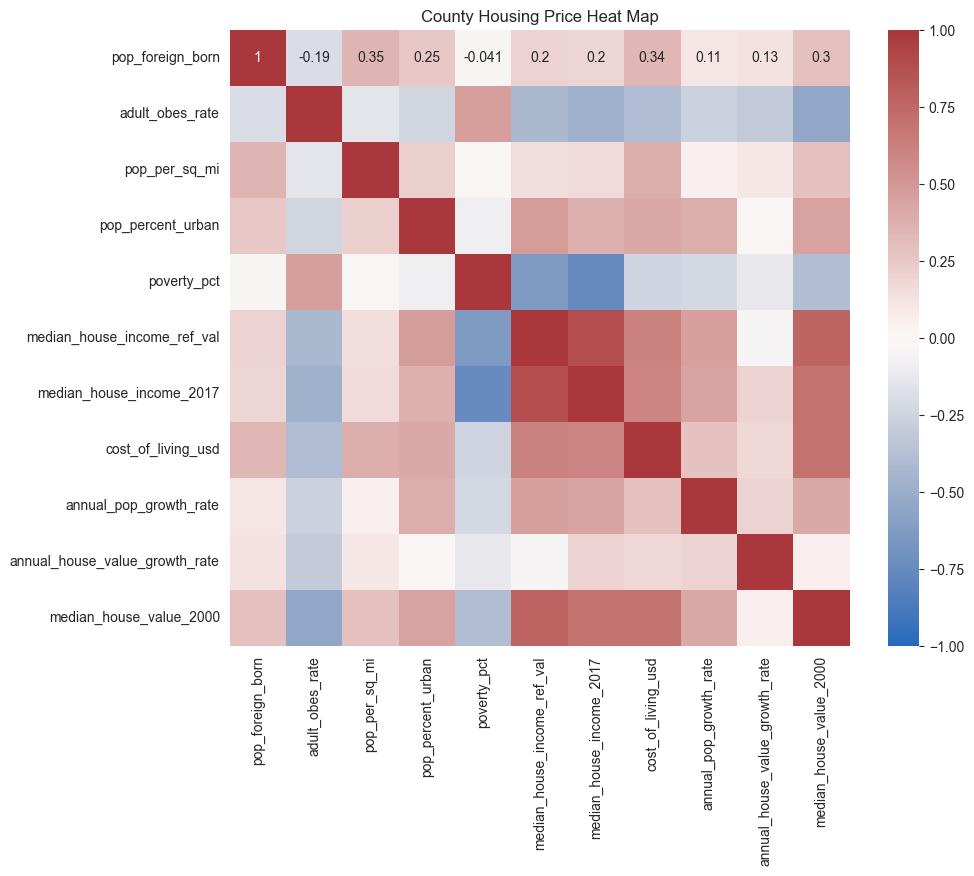

In [256]:
fig, ax = plt.subplots(figsize=(10,8))
ax = sns.heatmap(df.corr(), vmin=-1, vmax=1, cmap ='vlag', annot=True)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.set_yticklabels(ax.get_yticklabels(),rotation=0)
ax.set_title('County Housing Price Heat Map')

# Seems income both in 2017 and the original reference year correlate strongly with median house value and with each other.

In [257]:
# 8) Normalize the data, then use PCA to transform the features into a new linearly independent feature set.
scaler = StandardScaler()
scaled_x_train = scaler.fit_transform(x_train)

In [258]:
pca = PCA()
pca.fit(scaled_x_train)
print(pca.explained_variance_ratio_)

[0.39226703 0.15367696 0.11611636 0.0938013  0.06526701 0.06174749
 0.04910667 0.04413346 0.01715056 0.00673317]


In [259]:
pca_features = pca.transform(scaled_x_train)
pca.components_[0] #this should descibe the first principal component as a linear combination of the features?

array([ 0.18465701, -0.31932858,  0.1882163 ,  0.28184254, -0.32978465,
        0.44203818,  0.45222699,  0.3761847 ,  0.28197449,  0.13921563])

In [260]:
pca_features = ['pc'+str(i) for i in range(1,len(pca.components_)+1)]
df_pca = pd.DataFrame(pca.transform(scaled_x_train),columns = pca_features)
df_pca

,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10
0,0.290310,-0.307536,1.623041,-0.503361,-0.243072,0.282649,-0.872838,-1.961831,-0.061127,-0.488969
1,0.061511,-0.765503,-0.012788,1.162694,0.240421,-0.308538,0.027543,-0.495050,0.041976,-0.248774
2,0.064360,-0.178797,-0.909867,-0.939160,0.429218,0.004260,0.887501,0.589842,-0.112921,-0.293105
3,-2.168595,0.466660,-0.279275,0.097722,-0.198708,0.487593,-0.257940,-0.237495,0.166547,0.062478
4,0.462451,-0.910569,2.518206,-0.560547,-0.659307,1.632447,-0.156610,-0.206373,-0.158120,0.758710
...,...,...,...,...,...,...,...,...,...,...
1877,0.162732,-1.202106,-0.731607,1.440321,0.079001,0.708614,0.575171,0.691753,-0.085352,-0.089383
1878,-0.719738,-0.697643,0.538657,1.418623,0.149320,-0.172150,0.248690,0.263049,0.029859,-0.158008
1879,0.122317,-0.623958,-1.200180,0.522280,0.314403,0.130322,-0.182693,-1.532004,-0.182917,0.149243
1880,2.600026,-0.691595,0.182817,-2.545209,-0.172074,1.353257,0.549324,-0.058405,0.295602,-0.057146


In [261]:
scores = []
for k in range(1,len(pca.components_)+1):
    # get the first k components
    df_temp = df_pca.iloc[:, 0:k]

    # train the model on training set
    lr = LinearRegression()
    lr.fit(df_temp,y_train)

    # score model on validation set
    # have to transform and get the right amount of input features
    score = lr.score(pca.transform(scaler.transform(x_val))[:, 0:k], y_val)
    scores.append(score)
    print(f"Components: {k},  Score{score}")

Components: 1,  Score0.6785274674131598
Components: 2,  Score0.6868644516561204
Components: 3,  Score0.7151805108836772
Components: 4,  Score0.7201902676698977
Components: 5,  Score0.720734970106417
Components: 6,  Score0.7238504342991929
Components: 7,  Score0.722417976570161
Components: 8,  Score0.7466559860870541
Components: 9,  Score0.7709983555387045
Components: 10,  Score0.7841590163534802


C:\repos\DS312\venv\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\repos\DS312\venv\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\repos\DS312\venv\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\repos\DS312\venv\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\repos\DS312\venv\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\repos\DS312\venv\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but Li

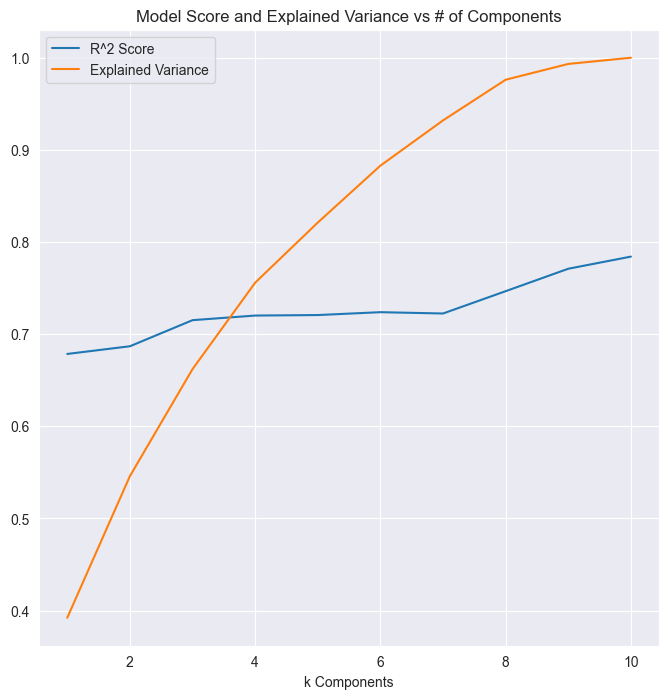

In [262]:
fig, ax = plt.subplots(figsize=(8,8))
ax.plot(range(1,len(pca.components_)+1), scores)
ax.plot(range(1,len(pca.components_)+1), np.cumsum(pca.explained_variance_ratio_))
ax.set_title('Model Score and Explained Variance vs # of Components')
ax.set_xlabel('k Components')
ax.legend(['R^2 Score', 'Explained Variance'])

In [263]:
np.cumsum(pca.explained_variance_ratio_)

array([0.39226703, 0.54594399, 0.66206034, 0.75586165, 0.82112866,
       0.88287615, 0.93198281, 0.97611627, 0.99326683, 1.        ])